In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import cv2
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay




In [ ]:

base_path = "C:/Users/ptoma/Desktop/archive"

#we sent 500 images of each class to a separate test file
test_path  = "C:/Users/ptoma/Desktop/test"

# quickly verifying the available classes
classes = os.listdir(base_path)
print(f"Classes encontradas: {classes}")


for classe in classes:
    class_path = os.path.join(base_path, classe)
    num_images = len(os.listdir(class_path))
    print(f"{classe}: {num_images} imagens")



#there will only be 4500 images (instead of the original 5000) per class on the archive because, as we mentioned, we ran a script to send 500 images of each class to a new test file


Classes encontradas: ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']
adenocarcinoma: 4500 imagens
benign: 4500 imagens
squamous_cell_carcinoma: 4500 imagens


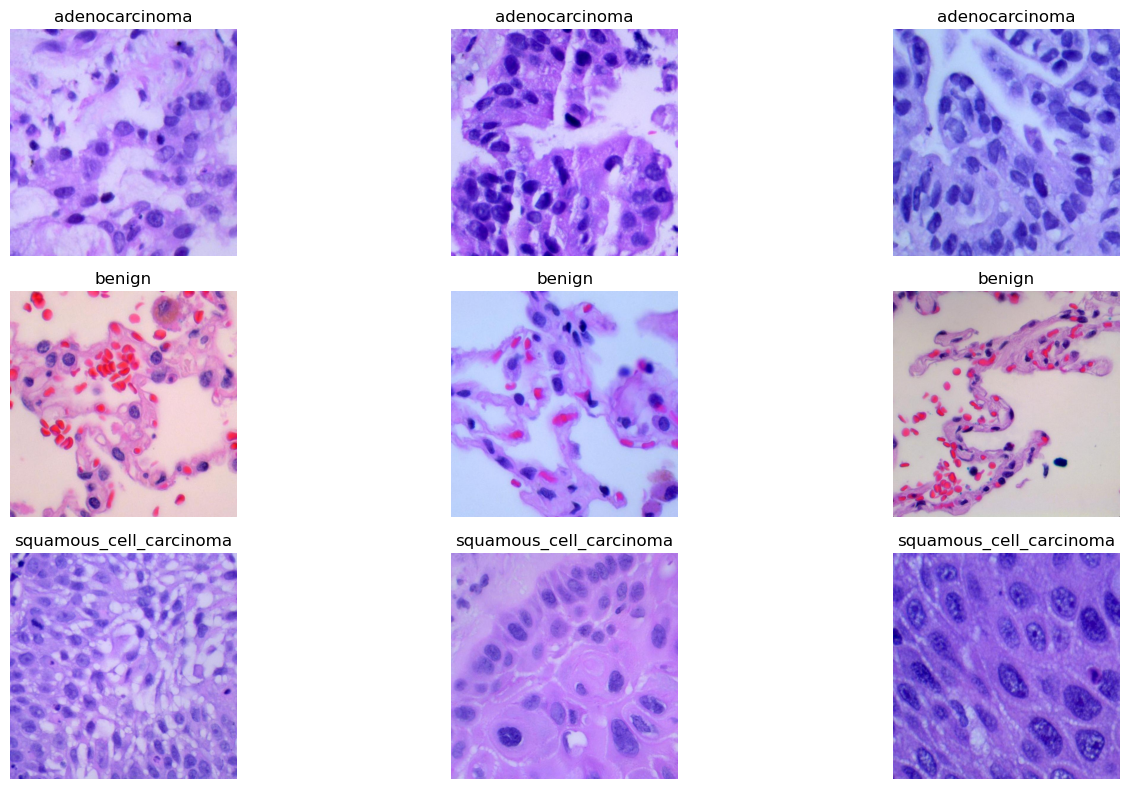

In [3]:
def show_sample_images(base_path, classes, samples_per_class=3):
    plt.figure(figsize=(15, 8))
    for i, classe in enumerate(classes):
        class_path = os.path.join(base_path, classe)
        images = os.listdir(class_path)
        for j in range(samples_per_class):
            img_path = os.path.join(class_path, random.choice(images))
            img = Image.open(img_path)
            plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.title(classe)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(base_path, classes)


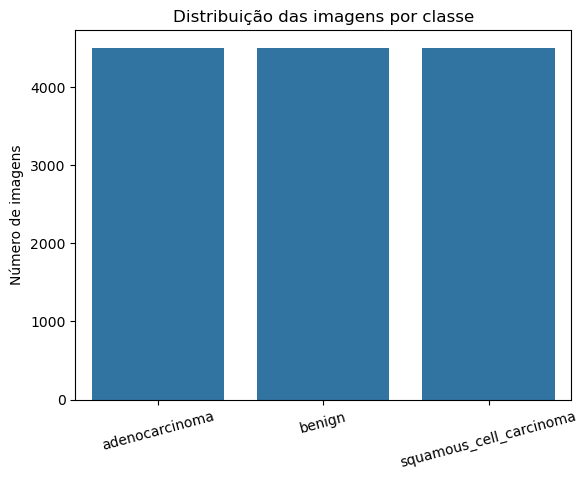

In [4]:
class_counts = {classe: len(os.listdir(os.path.join(base_path, classe))) for classe in classes}
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Distribuição das imagens por classe")
plt.ylabel("Número de imagens")
plt.xticks(rotation=15)
plt.show()


In [ ]:

img_size = (64, 64) #for now, in  the mlp, we will resize the images to 64 x 64 because the mlp will simply flatten them and it there would be no advantage in using higher resolutions ( for now)

batch_size = 32

#creating 
datagen = ImageDataGenerator(
    rescale=1./255,  #normalizing the pixel values to a [0,1] interval, improving the performance and stability of the model
    validation_split=0.1,
    #rotation_range=20,  #we can create new variations of the images, introducing rotations, zooms and so on to avoid overfitting
   # width_shift_range=0.2,  
    #height_shift_range=0.2,  
    #shear_range=0.2,  
    #zoom_range=0.2, 
    #horizontal_flip=True  
)



train_generator = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)


val_generator = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,                   
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False                 
)

Found 12150 images belonging to 3 classes.
Found 1350 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


MLP - MULTI LAYER PERCEPTRON

In [ ]:


# when the val_loss worsens after 3 epochs, it stops and restores the wieghts that provided the best results
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


checkpoint = ModelCheckpoint(
    filepath='melhor_modelo.h5',      
    monitor='val_loss',               
    save_best_only=True,              
    save_weights_only=False,          
    verbose=1                         
)

# MLP architecture
mlp_tuned = Sequential([
    Flatten(input_shape=(64, 64, 3)),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

mlp_tuned.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# fitting the mlp to the training data with callbacks
history_tuned = mlp_tuned.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.5369 - loss: 0.9300
Epoch 1: val_loss improved from inf to 0.52961, saving model to melhor_modelo.h5


380/380 ━━━━━━━━━━━━━━━━━━━━ 266s 697ms/step - accuracy: 0.5371 - loss: 0.9294 - val_accuracy: 0.6867 - val_loss: 0.5296
Epoch 2/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.6815 - loss: 0.5724
Epoch 2: val_loss improved from 0.52961 to 0.48838, saving model to melhor_modelo.h5


380/380 ━━━━━━━━━━━━━━━━━━━━ 338s 890ms/step - accuracy: 0.6815 - loss: 0.5723 - val_accuracy: 0.7452 - val_loss: 0.4884
Epoch 3/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7191 - loss: 0.5292
Epoch 3: val_loss did not improve from 0.48838
380/380 ━━━━━━━━━━━━━━━━━━━━ 488s 1s/step - accuracy: 0.7190 - loss: 0.5293 - val_accuracy: 0.7600 - val_loss: 0.4926
Epoch 4/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7182 - loss: 0.5226
Epoch 4: val_loss did not improve from 0.48838
380/380 ━━━━━━━━━━━━━━━━━━━━ 532s 1s/step - accuracy: 0.7182 - loss: 0.5226 - val_accuracy: 0.7726 - val_loss: 0.5057
Epoch 5/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.7370 - loss: 0.5039
Epoch 5: val_loss improved from 0.48838 to 0.46298, saving model to melhor_modelo.h5


380/380 ━━━━━━━━━━━━━━━━━━━━ 297s 779ms/step - accuracy: 0.7370 - loss: 0.5039 - val_accuracy: 0.7630 - val_loss: 0.4630
Epoch 6/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.7476 - loss: 0.4980
Epoch 6: val_loss did not improve from 0.46298
380/380 ━━━━━━━━━━━━━━━━━━━━ 176s 463ms/step - accuracy: 0.7476 - loss: 0.4980 - val_accuracy: 0.7659 - val_loss: 0.4671
Epoch 7/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7564 - loss: 0.4895
Epoch 7: val_loss did not improve from 0.46298
380/380 ━━━━━━━━━━━━━━━━━━━━ 136s 357ms/step - accuracy: 0.7564 - loss: 0.4895 - val_accuracy: 0.7711 - val_loss: 0.4842
Epoch 8/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.7564 - loss: 0.4895
Epoch 8: val_loss did not improve from 0.46298
380/380 ━━━━━━━━━━━━━━━━━━━━ 140s 368ms/step - accuracy: 0.7564 - loss: 0.4896 - val_accuracy: 0.7748 - val_loss: 0.4933


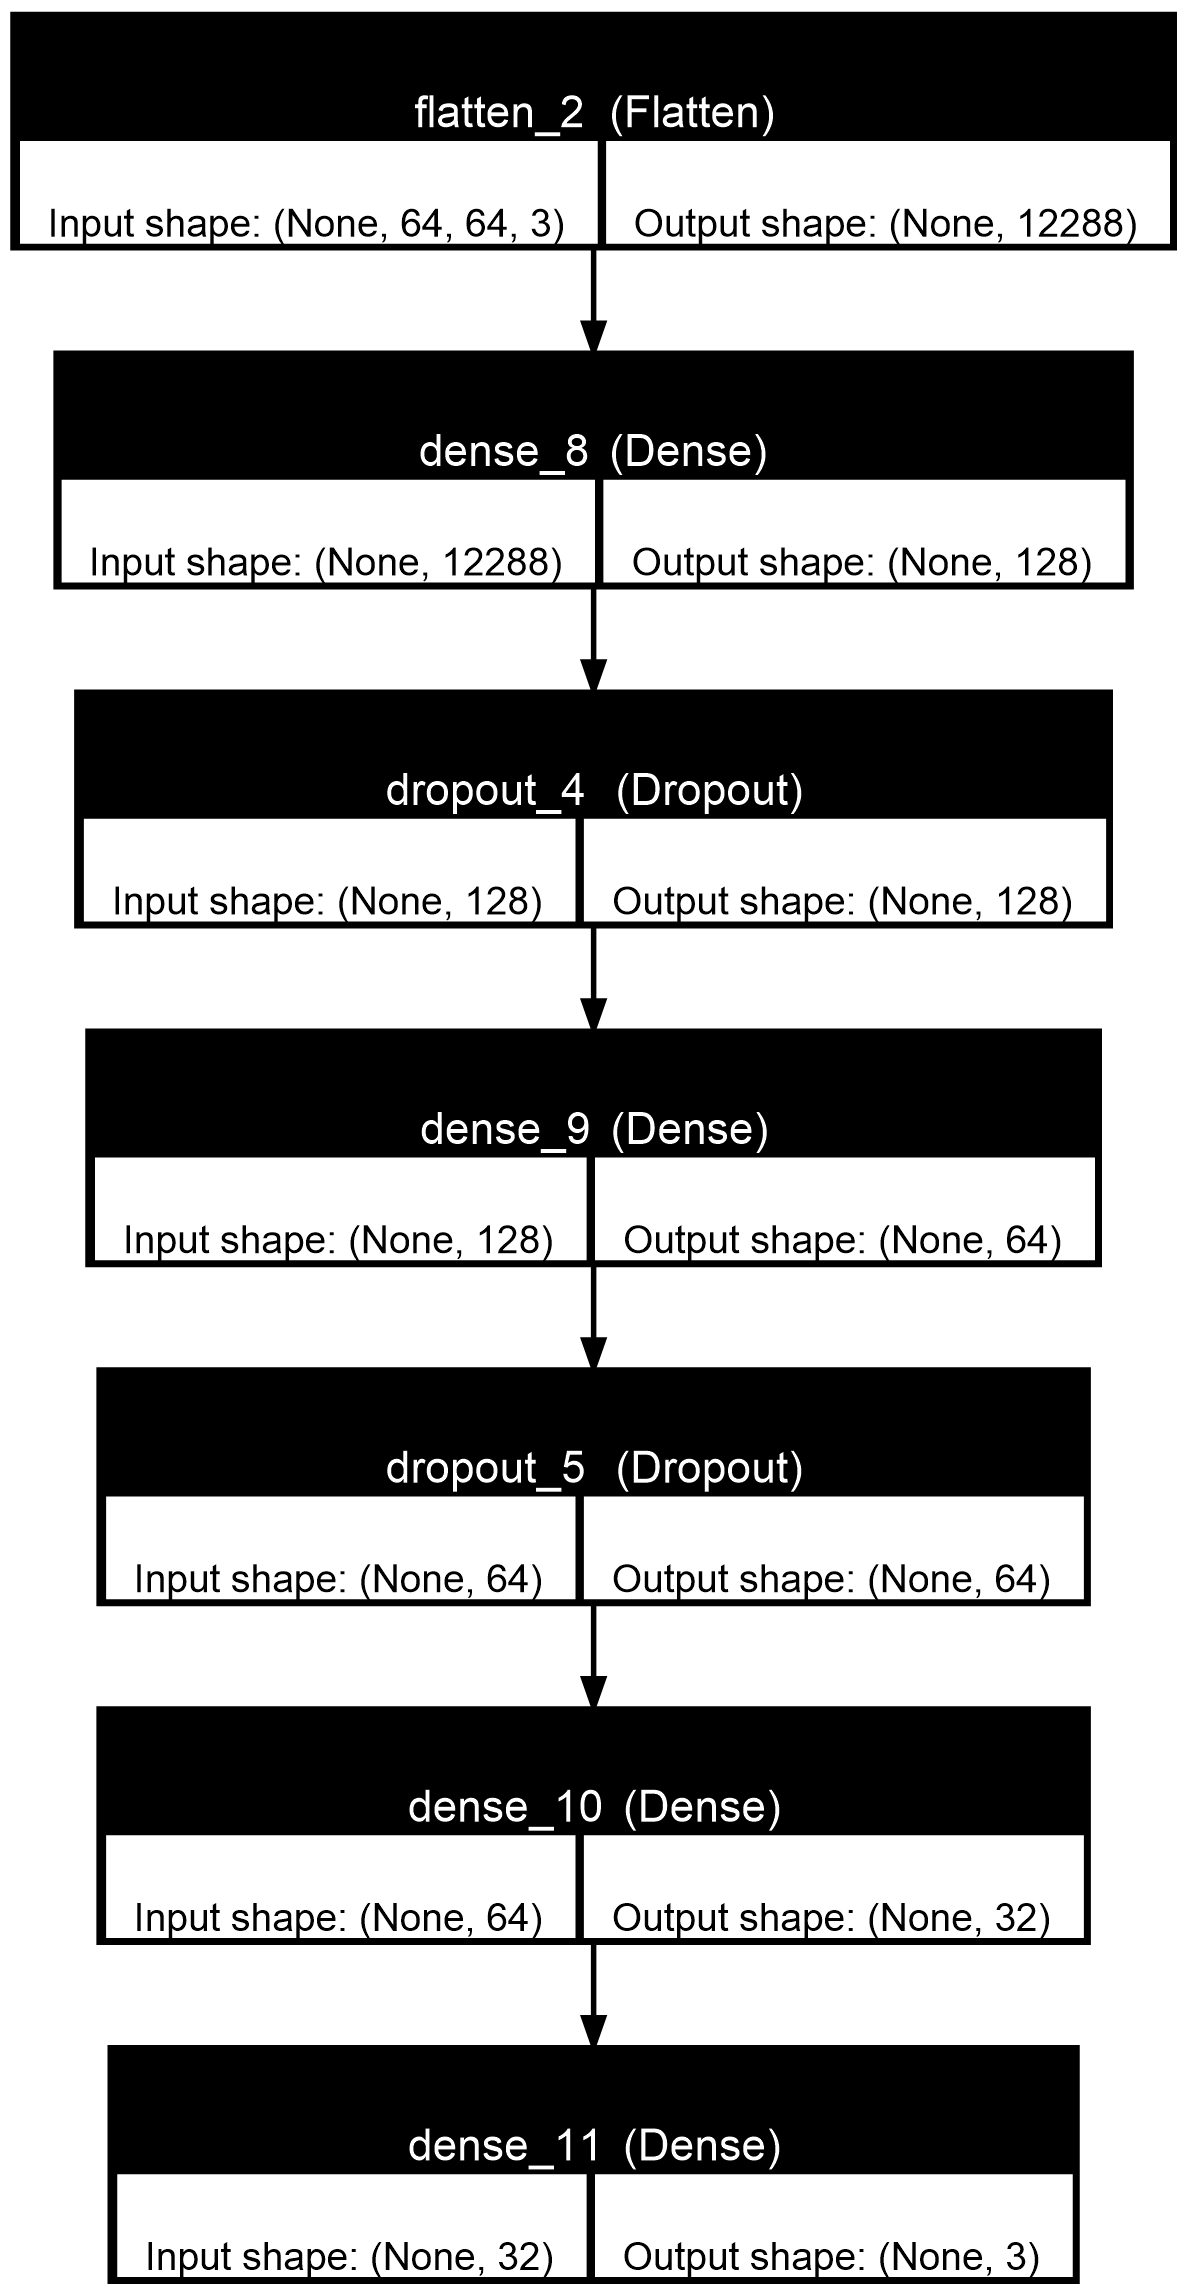

In [ ]:
#generating an image of the structure of the model (for the presentations)

plot_model(mlp_tuned, to_file="mlp_tuned_model.png", show_shapes=True, show_layer_names=True)


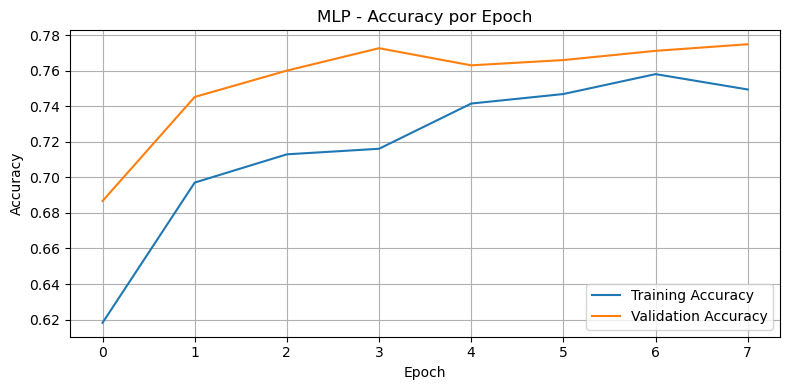

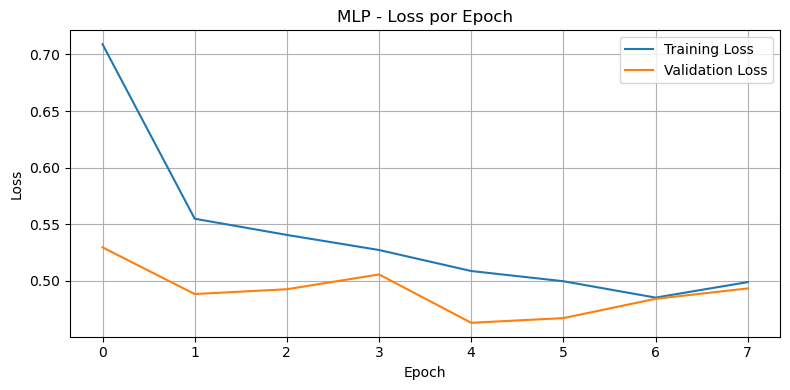

43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 262ms/step
📋 Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.66      0.59      0.62       450
                 benign       0.98      0.93      0.96       450
squamous_cell_carcinoma       0.66      0.77      0.71       450

               accuracy                           0.76      1350
              macro avg       0.77      0.76      0.76      1350
           weighted avg       0.77      0.76      0.76      1350



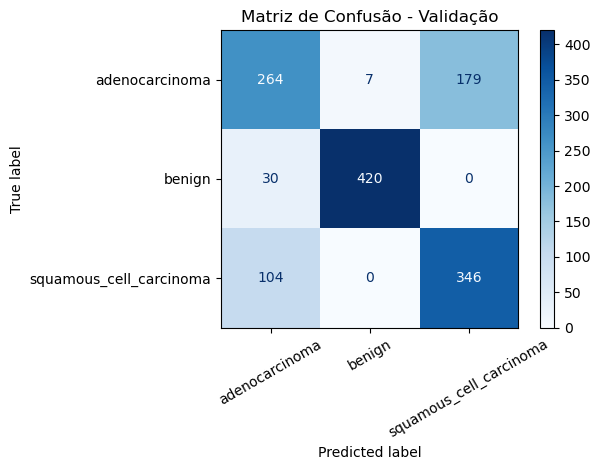

In [ ]:


# accuracy plot
plt.figure(figsize=(8, 4))
plt.plot(history_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_tuned.history['val_accuracy'], label='Validation Accuracy')

plt.title('MLP - Accuracy por Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# loss plot
plt.figure(figsize=(8, 4))
plt.plot(history_tuned.history['loss'], label='Training Loss')
plt.plot(history_tuned.history['val_loss'], label='Validation Loss')

plt.title('MLP - Loss por Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# predicting on the validation set
val_generator.reset()  
pred_probs = mlp_tuned.predict(val_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# report with precision, recall and f1
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix to visually and easily rate the model's performance
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=30)
plt.title("Matriz de Confusão - Validação")
plt.tight_layout()
plt.show()


Found 1500 images belonging to 3 classes.


c:\Users\dcris\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 30s 642ms/step - accuracy: 0.6960 - loss: 0.5507
Test Loss: 0.4382
Test Accuracy: 0.7740
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step
📋 Classification Report - Test Set:
                         precision    recall  f1-score   support

         adenocarcinoma       0.69      0.59      0.64       500
                 benign       0.99      0.96      0.97       500
squamous_cell_carcinoma       0.66      0.77      0.71       500

               accuracy                           0.77      1500
              macro avg       0.78      0.77      0.77      1500
           weighted avg       0.78      0.77      0.77      1500



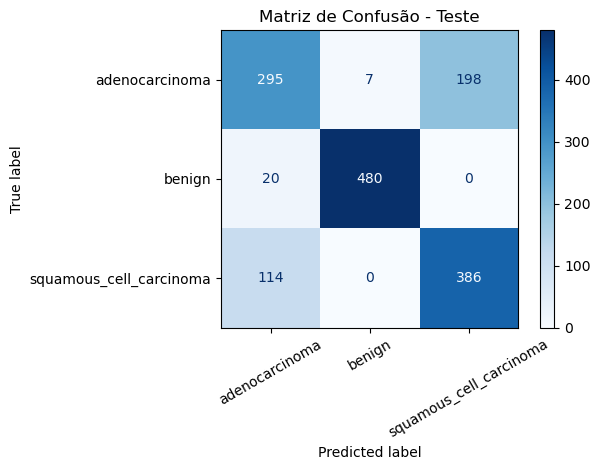

In [ ]:


# evaluating the mlp now on the test set

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
results = mlp_tuned.evaluate(test_generator)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

test_generator.reset()

test_probs = mlp_tuned.predict(test_generator)
y_test_pred = np.argmax(test_probs, axis=1)
y_test_true = test_generator.classes
class_labels_test = list(test_generator.class_indices.keys())


print("Classification Report - Test Set:")
print(classification_report(y_test_true, y_test_pred, target_names=class_labels_test))


cm_test = confusion_matrix(y_test_true, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_labels_test)
disp_test.plot(cmap='Blues', xticks_rotation=30)
plt.title("Matriz de Confusão - Teste")
plt.tight_layout()
plt.show()


CNN - CONVOLUTIONAL NEURAL NETWORK

In [ ]:
#defining the cnn architecture

model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128,128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


c:\Users\ptoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,793,859 (25.92 MB)

 Trainable params: 6,793,859 (25.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#fitting the cnn to the training data

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    #verbose=1
)

c:\Users\ptoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
380/380 ━━━━━━━━━━━━━━━━━━━━ 306s 801ms/step - accuracy: 0.7236 - loss: 0.5709 - val_accuracy: 0.8881 - val_loss: 0.2452
Epoch 2/5
380/380 ━━━━━━━━━━━━━━━━━━━━ 312s 821ms/step - accuracy: 0.8929 - loss: 0.2617 - val_accuracy: 0.9037 - val_loss: 0.2223
Epoch 3/5
380/380 ━━━━━━━━━━━━━━━━━━━━ 266s 700ms/step - accuracy: 0.9148 - loss: 0.2017 - val_accuracy: 0.9178 - val_loss: 0.2160
Epoch 4/5
380/380 ━━━━━━━━━━━━━━━━━━━━ 333s 877ms/step - accuracy: 0.9329 - loss: 0.1625 - val_accuracy: 0.8970 - val_loss: 0.2826
Epoch 5/5
380/380 ━━━━━━━━━━━━━━━━━━━━ 304s 800ms/step - accuracy: 0.9345 - loss: 0.1684 - val_accuracy: 0.9444 - val_loss: 0.1466


43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step
📊 Avaliação no conjunto de VALIDAÇÃO
                         precision    recall  f1-score   support

         adenocarcinoma       0.91      0.92      0.92       450
                 benign       1.00      0.99      0.99       450
squamous_cell_carcinoma       0.92      0.92      0.92       450

               accuracy                           0.94      1350
              macro avg       0.94      0.94      0.94      1350
           weighted avg       0.94      0.94      0.94      1350



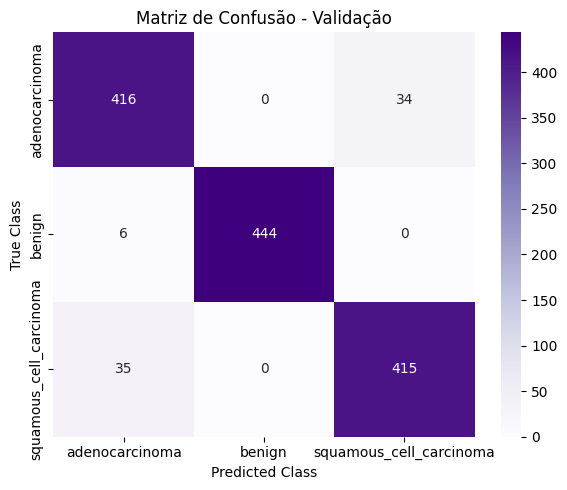

In [ ]:


val_preds_probs = model.predict(val_generator)
val_preds = np.argmax(val_preds_probs, axis=1)
val_true = val_generator.classes

class_names = list(val_generator.class_indices.keys())


print("Avaliação no conjunto de Validação")
print(classification_report(val_true, val_preds, target_names=class_names))


cm_val = confusion_matrix(val_true, val_preds)

plt.figure(figsize=(6,5))
plt.title("Matriz de Confusão - Validação")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()


c:\Users\ptoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 451ms/step - accuracy: 0.9418 - loss: 0.1465

✅ Acurácia no conjunto de TESTE: 94.67%
📉 Loss no conjunto de TESTE: 0.1369
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step

📊 Avaliação detalhada no conjunto de TESTE
                         precision    recall  f1-score   support

         adenocarcinoma       0.92      0.93      0.92       500
                 benign       1.00      0.98      0.99       500
squamous_cell_carcinoma       0.93      0.94      0.93       500

               accuracy                           0.95      1500
              macro avg       0.95      0.95      0.95      1500
           weighted avg       0.95      0.95      0.95      1500



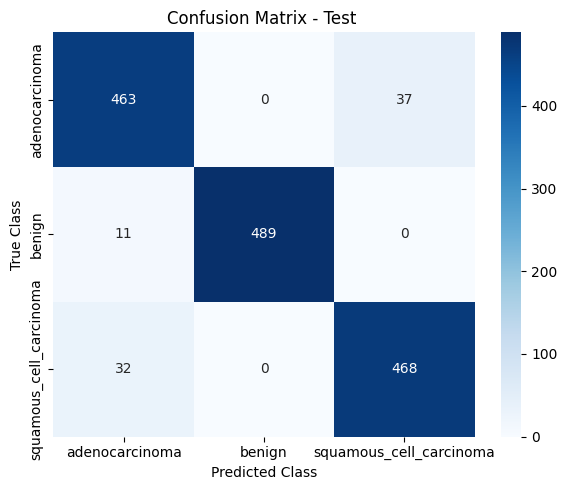

In [ ]:
#finally, evaluating the cnn on the test set

test_loss, test_acc = model.evaluate(test_generator)
print(f"\n Accuracy no conjunto de TESTE: {test_acc:.2%}")
print(f"Loss no conjunto de TESTE: {test_loss:.4f}")


test_preds_probs = model.predict(test_generator)
test_preds = np.argmax(test_preds_probs, axis=1)
test_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())


print("\nAvaliação detalhada no conjunto de TESTE")
print(classification_report(test_true, test_preds, target_names=class_names))


cm_test = confusion_matrix(test_true, test_preds)

plt.figure(figsize=(6,5))
plt.title("Confusion Matrix - Test ")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()
